# Playground Series - Season 4, Episode 1 - Binary Classification with a Bank Churn Dataset

In [25]:
#basics
import numpy as np
import pandas as pd
import seaborn as sns
import time
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
display = pd.options.display
display.max_columns = None

#preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import QuantileTransformer, quantile_transform

#statistics
from scipy import stats
from scipy.stats import skew
from scipy.special import boxcox1p


#feature engineering
from sklearn.feature_selection import mutual_info_classif


#transformers and pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn import set_config


#algorithms
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


#model evaluation
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, log_loss, f1_score, fbeta_score, auc, balanced_accuracy_score
from sklearn.metrics import make_scorer, accuracy_score, RocCurveDisplay, confusion_matrix, recall_score

# Optuna and visualization tools
import optuna
from optuna.samplers import TPESampler
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

# Dealing with imbalanced target
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline

#Stacking & ensembling
from sklearn.model_selection import GridSearchCV
from mlxtend.classifier import StackingCVClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier

random_state = 42

## READING FILES

**Bank Customer Churn Dataset**

The Bank Customer Churn Dataset is a commonly used dataset for predicting customer churn in the banking industry. It contains information on bank customers who either left the bank or continue to be customers. The dataset includes the following attributes:
- Customer ID: A unique identifier for each customer.
- Surname: The customer's surname or last name.
- Credit Score: A numerical value representing the customer's credit score.
- Geography: The country where the customer resides (France, Spain, or Germany).
- Gender: The customer's gender (Male or Female).
- Age: The customer's age.
- Tenure: The number of years the customer has been with the bank.
- Balance: The customer's account balance.
- NumOfProducts: The number of bank products the customer uses (e.g., savings account, credit card).
- HasCrCard: Whether the customer has a credit card (1 = yes, 0 = no).
- IsActiveMember: Whether the customer is an active member (1 = yes, 0 = no).
- EstimatedSalary: The estimated salary of the customer.
- Exited: Whether the customer has churned (1 = yes, 0 = no).

In [26]:
train_df = pd.read_csv('data/train.csv', index_col='id')
test_df = pd.read_csv('data/test.csv',index_col='id')
submission = pd.read_csv('data/sample_submission.csv')

## 1) EDA - Exploratory Data Analysis

In [27]:
train_df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
id,,,,,,,,,,,,,
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


### 1.1) data summary information

In [28]:
# create a summary table for the training data
summary_table = pd.DataFrame(train_df.dtypes, columns=['dtypes'])
summary_table['Missing'] = train_df.isnull().sum()
summary_table['Unique'] = train_df.nunique()
summary_table['Count'] = train_df.count()
summary_table['Duplicated'] = train_df.duplicated().sum()
summary_table

,dtypes,Missing,Unique,Count,Duplicated
CustomerId,int64,0,23221,165034,0
Surname,object,0,2797,165034,0
CreditScore,int64,0,457,165034,0
Geography,object,0,3,165034,0
Gender,object,0,2,165034,0
Age,float64,0,71,165034,0
Tenure,int64,0,11,165034,0
Balance,float64,0,30075,165034,0
NumOfProducts,int64,0,4,165034,0
HasCrCard,float64,0,2,165034,0


0    0.788401
1    0.211599
Name: Exited, dtype: float64


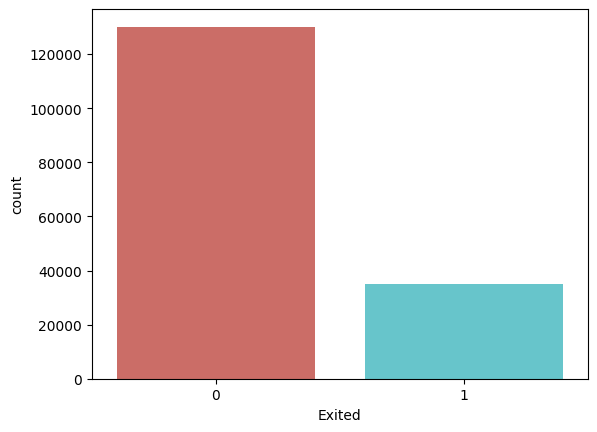

In [29]:
# let's look at the target variable
print(train_df['Exited'].value_counts(normalize=True))


# let's look at the distribution of the target variable
sns.countplot(x='Exited', data=train_df, palette='hls'); #imbalanced dataset

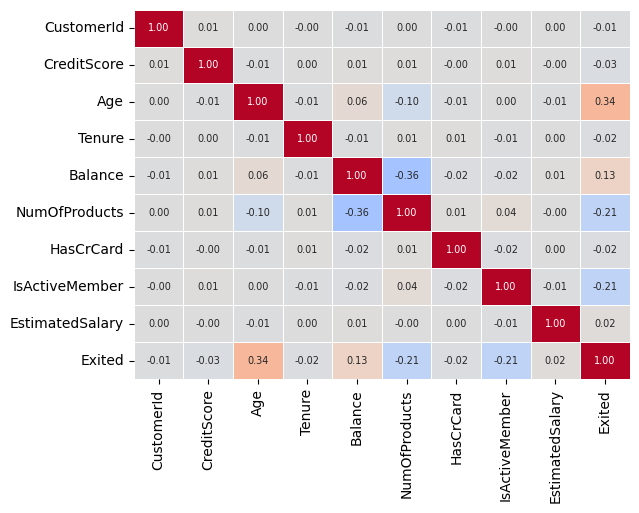

In [30]:
correlation_matrix = train_df.select_dtypes(exclude='object').corr()
column_names = correlation_matrix.columns
sns.heatmap(correlation_matrix.round(2),
            xticklabels=column_names,
            yticklabels=column_names,
            cmap="coolwarm",
            vmin=-1,
            vmax=1,
            annot=True,
            fmt=".2f",
            linewidths=0.5,
            annot_kws={"size": 7},
            cbar=False);


## 2) PreProcess Data

In [31]:
# class transformer that will help us to create the new features Surname_Length, Surname_Frequency and Surname_Ratio_Frequency_Length
class CreateSurnameFeatures(BaseEstimator, TransformerMixin):
    """This class helps to create new features based on the 'Surname' column."""
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        data = X.copy()
        data['Surname_Length'] = data['Surname'].apply(len)
        data['Surname_Frequency'] = data['Surname'].map(data['Surname'].value_counts())
        data['Surname_Ratio_Frequency_Length'] = data['Surname_Frequency'] / data['Surname_Length']
        return data

    def get_feature_names_out(self, input_features=None):
            if input_features is None:
                return ['Surname_Length', 'Surname_Frequency', 'Surname_Ratio_Frequency_Length']
            return input_features + ['Surname_Length', 'Surname_Frequency', 'Surname_Ratio_Frequency_Length']

# this class will create a new feature based on balance to salary ratio
class BalanceSalaryRatio(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        data = X.copy()
        data['BalanceSalaryRatio'] = data['Balance'] / data['EstimatedSalary']
        return data

    def get_feature_names_out(self, input_features=None):
        return input_features + ['BalanceSalaryRatio']

# this class will create a new feature of num of products and has card interaction
class NumOfProductsHasCrCardInteraction(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        data = X.copy()
        data['NumOfProductsHasCrCardInteraction'] = data['NumOfProducts'] * data['HasCrCard']
        return data

    def get_feature_names_out(self, input_features=None):
        return input_features + ['NumOfProductsHasCrCardInteraction']

# this class will create a new feature based on the relation between balance and number of products
class BalanceNumOfProductsInteraction(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        data = X.copy()
        data['BalanceNumOfProductsInteraction'] = data['Balance'] * data['NumOfProducts']
        return data

    def get_feature_names_out(self, input_features=None):
        return input_features + ['BalanceNumOfProductsInteraction']

# this class will create a new feature based on age and number of products
class AgeNumOfProductsInteraction(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        data = X.copy()
        data['AgeNumOfProductsInteraction'] = data['Age'] * data['NumOfProducts']
        return data

    def get_feature_names_out(self, input_features=None):
        return input_features + ['AgeNumOfProductsInteraction']

# this class will create a new feature based on tenure and age ratio
class TenureAgeRatio(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        data = X.copy()
        data['TenureAgeRatio'] = data['Tenure'] / data['Age']
        return data

    def get_feature_names_out(self, input_features=None):
        return input_features + ['TenureAgeRatio']

# this class will create a new  feature based on based on tenure and is active member and class it LoyaltyScore
class LoyaltyScore(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        data = X.copy()
        data['LoyaltyScore'] = data['Tenure'] * data['IsActiveMember']
        return data

    def get_feature_names_out(self, input_features=None):
        return input_features + ['LoyaltyScore']

# this class will help us bin the age variable
class AgeBinner(BaseEstimator, TransformerMixin):
    def __init__(self, num_bins):
        self.num_bins = num_bins

    def fit(self, X, y=None):
        # Calculate bin edges dynamically based on data distribution
        _, bin_edges = pd.cut(X['Age'], bins=self.num_bins, retbins=True)
        self.bin_edges = bin_edges
        return self

    def transform(self, X):
        data = X.copy()
        bin_labels = [f'{int(self.bin_edges[i])}-{int(self.bin_edges[i+1])}' for i in range(len(self.bin_edges)-1)]
        data['Age_Bins'] = pd.cut(data['Age'], bins=self.bin_edges, labels=bin_labels, precision=0)
        data['Age_Bins'] = data['Age_Bins'].astype('object')
        return data

    def get_feature_names_out(self, input_features=None):
        return [col for col in input_features if col not in ['Age']]

# this class will help us bin credit score
class CreditScoreBinner(BaseEstimator, TransformerMixin):
    def __init__(self, num_bins):
        self.num_bins = num_bins

    def fit(self, X, y=None):
        # Calculate bin edges dynamically based on data distribution
        _, bin_edges = pd.cut(X['CreditScore'], bins=self.num_bins, retbins=True)
        self.bin_edges = bin_edges
        return self

    def transform(self, X):
        data = X.copy()
        bin_labels = [f'{int(self.bin_edges[i])}-{int(self.bin_edges[i+1])}' for i in range(len(self.bin_edges)-1)]
        data['CreditScore_Bins'] = pd.cut(data['CreditScore'], bins=self.bin_edges, labels=bin_labels, precision=0)
        data['CreditScore_Bins'] = data['CreditScore_Bins'].astype('object')
        return data

    def get_feature_names_out(self, input_features=None):
        return [col for col in input_features if col not in ['CreditScore']]

# class helps select columns categorical or numerical columns
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, dtypes=None):
        self.columns = columns
        self.dtypes = dtypes

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        data = X.copy()
        if self.columns:
            data = data[self.columns]
        if self.dtypes:
            data = data.select_dtypes(include=self.dtypes)
        return data

    def get_feature_names_out(self, input_features=None):
        return [col for col in input_features if col in self.columns]

# ----------------------------------

# feature engineering pipeline
feat_pipeline = Pipeline([
    ('surname_features', CreateSurnameFeatures()),
    ('balance_salary_ratio', BalanceSalaryRatio()),
    ('num_of_products_has_cr_card_interaction', NumOfProductsHasCrCardInteraction()),
    ('balance_num_of_products_interaction', BalanceNumOfProductsInteraction()),
    ('age_num_of_products_interaction', AgeNumOfProductsInteraction()),
    ('tenure_age_ratio', TenureAgeRatio()),
    ('loyalty_score', LoyaltyScore()),
    ('bin_age', AgeBinner(num_bins=10)),
    ('bin_credit_score', CreditScoreBinner(num_bins=10)),
])

feat_pipeline

Pipeline(steps=[('surname_features', CreateSurnameFeatures()),
                ('balance_salary_ratio', BalanceSalaryRatio()),
                ('num_of_products_has_cr_card_interaction',
                 NumOfProductsHasCrCardInteraction()),
                ('balance_num_of_products_interaction',
                 BalanceNumOfProductsInteraction()),
                ('age_num_of_products_interaction',
                 AgeNumOfProductsInteraction()),
                ('tenure_age_ratio', TenureAgeRatio()),
                ('loyalty_score', LoyaltyScore()),
                ('bin_age', AgeBinner(num_bins=10)),
                ('bin_credit_score', CreditScoreBinner(num_bins=10))])

In [47]:
class DropUnwantedColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            data = X.copy()
            return data.drop(labels=self.columns, axis='columns')
        elif isinstance(X, np.ndarray):
            # Assuming X is a NumPy array with columns
            df = pd.DataFrame(X, columns=self.columns)
            return df.drop(labels=self.columns, axis='columns').to_numpy()
        else:
            raise ValueError("Unsupported input type. Expecting pandas DataFrame or NumPy array.")

    def get_feature_names_out(self, input_features=None):
        if isinstance(input_features, list):
            return [col for col in input_features if col not in self.columns]
        else:
            return input_features



# identifying categorical do encode
cat_ohe_features = ['Age_Bins','CreditScore_Bins','Tenure','Geography','Gender','NumOfProducts']

# identifying numerical features to scale
num_features = ['EstimatedSalary', 'Surname_Length', 'Surname_Frequency', 'Surname_Ratio_Frequency_Length' \
    ,'BalanceSalaryRatio', 'NumOfProductsHasCrCardInteraction','TenureAgeRatio','LoyaltyScore','BalanceNumOfProductsInteraction'\
    ,'AgeNumOfProductsInteraction','Balance']

# identifying feature to drop after encoding
columns_to_drop = ['CustomerId', 'Surname', 'Age', 'CreditScore']

# categorical pipeline
cat_pipeline = Pipeline([
    ('cat_selector', ColumnSelector(columns=cat_ohe_features)),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

# numerical pipeline
num_pipeline = Pipeline([
    ('num_selector', ColumnSelector(columns=num_features)),
    ('scaler', RobustScaler())
])

# Column drop pipeline
drop_columns_pipeline = Pipeline([
    ('drop_unwanted', DropUnwantedColumns(columns=columns_to_drop))
])

# Combined feature processing pipeline
feature_processing_pipeline = FeatureUnion([
    ('categorical_pipeline', cat_pipeline),
    ('numerical_pipeline', num_pipeline),

])

# Final pipeline
tree_preprocessor = Pipeline([
    ('feature_engineering', feat_pipeline),
    ('drop_columns', drop_columns_pipeline),
    ('feature_processing', feature_processing_pipeline),
])

tree_preprocessor


Pipeline(steps=[('feature_engineering',
                 Pipeline(steps=[('surname_features', CreateSurnameFeatures()),
                                 ('balance_salary_ratio', BalanceSalaryRatio()),
                                 ('num_of_products_has_cr_card_interaction',
                                  NumOfProductsHasCrCardInteraction()),
                                 ('balance_num_of_products_interaction',
                                  BalanceNumOfProductsInteraction()),
                                 ('age_num_of_products_interaction',
                                  AgeNumOfProduct...
                                                ('numerical_pipeline',
                                                 Pipeline(steps=[('num_selector',
                                                                  ColumnSelector(columns=['EstimatedSalary',
                                                                                          'Surname_Length',
                                                                                          'Surname_Frequency',
                                                                                          'Surname_Ratio_Frequency_Length',
                                                                                          'BalanceSalaryRatio',
                                                                                          'NumOfProductsHasCrCardInteraction',
                                                                                          'TenureAgeRatio',
                                                                                          'LoyaltyScore',
                                                                                          'BalanceNumOfProductsInteraction',
                                                                                          'AgeNumOfProductsInteraction',
                                                                                          'Balance'])),
                                                                 ('scaler',
                                                                  RobustScaler())]))]))])

In [62]:
# grabbing feature names after preprocessing
cat_names = tree_preprocessor.named_steps['feature_processing'].transformer_list[0][1].named_steps['ohe'].get_feature_names_out(cat_ohe_features)
num_names = tree_preprocessor.named_steps['feature_processing'].transformer_list[1][1].named_steps['num_selector'].get_feature_names_out(num_features)
feature_names = np.concatenate((cat_names, num_names))

# creating a new dataframe with the transformed features
X_train, X_test, y_train, y_test = train_test_split(train_df.drop('Exited', axis=1),
                                                    train_df['Exited'],
                                                    test_size=0.2,
                                                    random_state=random_state)

X_train = tree_preprocessor.fit_transform(X_train)
X_test = tree_preprocessor.transform(X_test)

# creating a dataframe with the transformed features
X_train = pd.DataFrame(X_train, columns=feature_names)
X_test = pd.DataFrame(X_test, columns=feature_names)

# creating a dataframe with the transformed features
test_df = tree_preprocessor.transform(test_df)
test_df = pd.DataFrame(test_df, columns=feature_names)

# creating a dataframe with the transformed features
train_df = tree_preprocessor.transform(train_df)
train_df = pd.DataFrame(train_df, columns=feature_names)


X_train.head()


,Age_Bins_17-25,Age_Bins_25-32,Age_Bins_32-40,Age_Bins_40-47,Age_Bins_47-55,Age_Bins_55-62,Age_Bins_62-69,Age_Bins_69-77,Age_Bins_77-84,Age_Bins_84-92,CreditScore_Bins_349-400,CreditScore_Bins_400-450,CreditScore_Bins_450-500,CreditScore_Bins_500-550,CreditScore_Bins_550-600,CreditScore_Bins_600-650,CreditScore_Bins_650-700,CreditScore_Bins_700-750,CreditScore_Bins_750-800,CreditScore_Bins_800-850,Tenure_0,Tenure_1,Tenure_2,Tenure_3,Tenure_4,Tenure_5,Tenure_6,Tenure_7,Tenure_8,Tenure_9,Tenure_10,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4,EstimatedSalary,Surname_Length,Surname_Frequency,Surname_Ratio_Frequency_Length,BalanceSalaryRatio,NumOfProductsHasCrCardInteraction,TenureAgeRatio,LoyaltyScore,BalanceNumOfProductsInteraction,AgeNumOfProductsInteraction,Balance
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-0.179041,1.333333,-0.026871,-0.122095,0.000000,1.0,0.667080,1.8,0.000000,0.742857,0.000000
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-0.186595,0.666667,-0.543186,-0.356718,1.151518,1.0,0.486073,0.0,1.767078,1.028571,0.963838
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.462613,-1.333333,-0.253359,0.321302,0.000000,0.0,0.085559,0.0,0.000000,-0.600000,0.000000
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,-0.131165,0.000000,-0.339731,-0.200083,0.551607,1.0,-0.264036,0.6,0.883293,0.171429,0.481785
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.199141,-0.666667,-0.370441,-0.154079,0.000000,1.0,-0.456313,0.0,0.000000,0.000000,0.000000


In [63]:
#SMOTE for oversampling of minority class(class 1)
sm = SMOTE(random_state=random_state)

## Base Models

In [64]:
# List all parameters found in hyperparameter tunning process

#lgm simple
lgbm_simple_params ={'n_estimators': 439,
                     'max_depth': 9,
                     'learning_rate': 0.0643282101361018,
                     'min_child_samples': 13,
                     'subsample': 0.38820330877513254,
                     'max_bin': 300,
                     'colsample_bytree': 0.43145735963996845}

#lgm with class weight
lgbm_class_weight_params ={'n_estimators': 498,
                           'max_depth': 6,
                           'learning_rate': 0.047359251329996195,
                           'min_child_samples': 20,
                           'subsample': 0.6377912907721486,
                           'max_bin': 260,
                           'colsample_bytree': 0.5372190078997091,
                           'scale_pos_weight': 0.9483441955116075}

#lgm with smote
lgbm_smote_params ={'n_estimators': 471,
                    'max_depth': 10,
                    'learning_rate': 0.0701731179061537,
                    'min_child_samples': 15,
                    'subsample': 0.20773967005308486,
                    'max_bin': 340,
                    'colsample_bytree': 0.3727961976310182}
#xgb simple
xgb_simple_params  = {'n_estimators': 281,
                      'alpha': 0.024722446617650117,
                      'subsample': 0.9092679197884052,
                      'colsample_bytree': 0.5036745487831261,
                      'max_depth': 6,
                      'min_child_weight': 3,
                      'learning_rate': 0.07531907957786994,
                      'gamma': 0.00016235463275744927}

#xgb with class weight
xgb_class_weight_params = {'n_estimators': 440,
                           'alpha': 0.0013751461960360158,
                           'subsample': 0.8076590076519942,
                           'colsample_bytree': 0.5573853166048716,
                           'max_depth': 5,
                           'min_child_weight': 2,
                           'learning_rate':  0.0636761270496045,
                           'gamma': 0.0003815606898277253,
                           'scale_pos_weight': 1.2999522592435082}
#xgb with smote
xgb_smote_params = {'n_estimators': 438,
                    'alpha': 0.11760883915536113,
                    'subsample': 0.94327313500221,
                    'colsample_bytree': 0.6605823804562506,
                    'max_depth': 7,
                    'min_child_weight': 3,
                    'learning_rate': 0.04529751888133378,
                    'gamma': 0.013560644038528798}

#histboosting simple
hst_simple_params ={'learning_rate': 0.06641262187295333,
                    'max_iter': 344,
                    'max_depth': 5,
                    'l2_regularization': 0.03411439940430499}

#histboosting with class weight
hst_class_weight_params = {'learning_rate': 0.08893052165501196,
                           'max_iter': 448,
                           'max_depth': 4,
                           'l2_regularization': 0.7792159019097559}

#histboosting with smote
hst_smote_params = {'learning_rate': 0.042008490752076494,
                    'max_iter': 488,
                    'max_depth': 12,
                    'l2_regularization': 0.7715407262993847}

#catboost simple
cat_simple_params = {'iterations': 490,
                     'colsample_bylevel': 0.4110936500315391,
                     'learning_rate':  0.09907817058056112,
                     'random_strength': 0.01727221302379271,
                     'depth': 5,
                     'l2_leaf_reg': 3,
                     'boosting_type': 'Plain',
                     'bootstrap_type': 'Bernoulli',
                     'subsample': 0.6767681550919736}

#catboost with class weight
cat_class_weight_params = {'iterations': 483,
                           'colsample_bylevel': 0.5318555699280899,
                           'learning_rate': 0.10233412103097894,
                           'random_strength': 0.09750092002974313,
                           'depth': 5,
                           'l2_leaf_reg': 4,
                           'boosting_type': 'Plain',
                           'bootstrap_type': 'Bernoulli',
                           'scale_pos_weight': 1.1383812115611798,
                           'subsample': 0.5894531469921895}



#catboost smote
cat_smote_params = {'iterations': 398,
                    'colsample_bylevel': 0.6963459781979415,
                    'learning_rate': 0.10304917629217605,
                    'random_strength': 0.06085528581164544,
                    'depth': 5,
                    'l2_leaf_reg': 3,
                    'boosting_type': 'Plain',
                    'bootstrap_type': 'Bernoulli',
                    'subsample': 0.7140099695149456}

In [65]:
#Construct pipelines

#lgbm pipes
lgbm_simple = LGBMClassifier(**lgbm_simple_params, random_state=random_state, verbose=-1)

pipe_lgbm_simple =imbpipeline([

    ('tree_preprocessor', tree_preprocessor),
    #('smote', sm),
    ("lgbm_tunned", lgbm_simple)
])



lgbm_class_weight = LGBMClassifier(**lgbm_class_weight_params, random_state=random_state, verbose=-1)

pipe_lgbm_class_weight =imbpipeline([

    ('tree_preprocessor', tree_preprocessor),
     #('smote', sm),
    ("lgbm_class_weight", lgbm_class_weight)
])



lgbm_smote = LGBMClassifier(**lgbm_smote_params, random_state=random_state, verbose=-1)

pipe_lgbm_smote =imbpipeline([

    ('tree_preprocessor', tree_preprocessor),
     ('smote', sm),
    ("lgbm_smote", lgbm_smote)
])



#xgboost pipes
xgb_simple = XGBClassifier(**xgb_simple_params, random_state=random_state)

pipe_xgb_simple =imbpipeline([

    ('tree_preprocessor', tree_preprocessor),
     #('smote', sm),
    ("xgb_simple", xgb_simple)
])




xgb_class_weight = XGBClassifier(**xgb_class_weight_params, random_state=random_state)

pipe_xgb_class_weight =imbpipeline([

    ('tree_preprocessor', tree_preprocessor),
     #('smote', sm),
    ("xgb_class_weight", xgb_class_weight)
])



xgb_smote = XGBClassifier(**xgb_smote_params, random_state=random_state)

pipe_xgb_smote =imbpipeline([

    ('tree_preprocessor', tree_preprocessor),
     ('smote', sm),
    ("xgb_smote", xgb_smote)
])



#hist pipes
hst_simple = HistGradientBoostingClassifier(**hst_simple_params, random_state=random_state)

pipe_hst_simple =imbpipeline([

    ('tree_preprocessor', tree_preprocessor),
     #('smote', sm),
    ("hst_simple", hst_simple)
])




hst_class_weight = HistGradientBoostingClassifier(**hst_class_weight_params, random_state=random_state, class_weight = 'balanced')

pipe_hst_class_weight =imbpipeline([

    ('tree_preprocessor', tree_preprocessor),
     #('smote', sm),
    ("hst_class_weight", hst_class_weight)
])


hst_smote = HistGradientBoostingClassifier(**hst_smote_params, random_state=random_state)

pipe_hst_smote =imbpipeline([

    ('tree_preprocessor', tree_preprocessor),
     ('smote', sm),
    ("hst_smote", hst_smote)
])


#cat boost pipes
cat_simple = CatBoostClassifier(**cat_simple_params, random_state =random_state, logging_level='Silent')

pipe_cat_simple =imbpipeline([

    ('tree_preprocessor', tree_preprocessor),
     #('smote', sm),
    ("cat_simple", cat_simple)
])




cat_class_weight = CatBoostClassifier(**cat_class_weight_params, random_state =random_state, logging_level='Silent')

pipe_cat_class_weight =imbpipeline([

    ('tree_preprocessor', tree_preprocessor),
     #('smote', sm),
    ("cat_class_weight", cat_class_weight)
])


cat_smote = CatBoostClassifier(**cat_smote_params, random_state =random_state, logging_level='Silent')

pipe_cat_smote =imbpipeline([

    ('tree_preprocessor', tree_preprocessor),
    ('smote', sm),
    ("cat_smote", cat_smote)
])

## Ensemble with simple Voting

In [66]:
estimators = [

    ('pipe_lgbm_simple', pipe_lgbm_simple),
    ('pipe_lgbm_class_weight', pipe_lgbm_class_weight),
    ('pipe_lgbm_smote', pipe_lgbm_smote),
    ('pipe_xgb_simple', pipe_xgb_simple),
    ('pipe_xgb_class_weight', pipe_xgb_class_weight),
    ("pipe_xgb_smote", pipe_xgb_smote),
    ("pipe_hst_simple", pipe_hst_simple),
    ("pipe_hst_smote", pipe_hst_smote),
    ("pipe_hst_class_weight", pipe_hst_class_weight),
    ("pipe_cat_simple", pipe_cat_simple),
    ("pipe_cat_class_weight", pipe_cat_class_weight),
    ("pipe_cat_smote", pipe_cat_smote)
]

In [67]:
Voting_ensemble = VotingClassifier(estimators=estimators, voting = 'soft')
Voting_ensemble

VotingClassifier(estimators=[('pipe_lgbm_simple',
                              Pipeline(steps=[('tree_preprocessor',
                                               Pipeline(steps=[('feature_engineering',
                                                                Pipeline(steps=[('surname_features',
                                                                                 CreateSurnameFeatures()),
                                                                                ('balance_salary_ratio',
                                                                                 BalanceSalaryRatio()),
                                                                                ('num_of_products_has_cr_card_interaction',
                                                                                 NumOfProductsHasCrCardInteraction()),
                                                                                ('balance_num_of_products_interaction'...
                                                                                                                                         'Surname_Ratio_Frequency_Length',
                                                                                                                                         'BalanceSalaryRatio',
                                                                                                                                         'NumOfProductsHasCrCardInteraction',
                                                                                                                                         'TenureAgeRatio',
                                                                                                                                         'LoyaltyScore',
                                                                                                                                         'BalanceNumOfProductsInteraction',
                                                                                                                                         'AgeNumOfProductsInteraction',
                                                                                                                                         'Balance'])),
                                                                                                                ('scaler',
                                                                                                                 RobustScaler())]))]))])),
                                              ('smote', SMOTE(random_state=42)),
                                              ('cat_smote',
                                               <catboost.core.CatBoostClassifier object at 0x2a7b404f0>)]))],
                 voting='soft')

## Ensemble with Stacking

In [68]:
stacking_ensemble = StackingClassifier(estimators=estimators, final_estimator = LogisticRegression(random_state=random_state, C = 0.00001))
stacking_ensemble

StackingClassifier(estimators=[('pipe_lgbm_simple',
                                Pipeline(steps=[('tree_preprocessor',
                                                 Pipeline(steps=[('feature_engineering',
                                                                  Pipeline(steps=[('surname_features',
                                                                                   CreateSurnameFeatures()),
                                                                                  ('balance_salary_ratio',
                                                                                   BalanceSalaryRatio()),
                                                                                  ('num_of_products_has_cr_card_interaction',
                                                                                   NumOfProductsHasCrCardInteraction()),
                                                                                  ('balance_num_of_products_interactio...
                                                                                                                                           'BalanceSalaryRatio',
                                                                                                                                           'NumOfProductsHasCrCardInteraction',
                                                                                                                                           'TenureAgeRatio',
                                                                                                                                           'LoyaltyScore',
                                                                                                                                           'BalanceNumOfProductsInteraction',
                                                                                                                                           'AgeNumOfProductsInteraction',
                                                                                                                                           'Balance'])),
                                                                                                                  ('scaler',
                                                                                                                   RobustScaler())]))]))])),
                                                ('smote',
                                                 SMOTE(random_state=42)),
                                                ('cat_smote',
                                                 <catboost.core.CatBoostClassifier object at 0x2a7b404f0>)]))],
                   final_estimator=LogisticRegression(C=1e-05, random_state=42))

In [63]:
#%%time

#models

#estimators = [pipe_lgbm_simple,
#              pipe_lgbm_class_weight,
#              pipe_lgbm_smote,
#              pipe_xgb_simple,
#              pipe_xgb_class_weight,
#              pipe_xgb_smote,
#              pipe_hst_simple,
#              pipe_hst_smote,
#              pipe_hst_class_weight,
#              pipe_cat_simple,
#              pipe_cat_class_weight,
#              pipe_cat_smote


#]

#meta model
#lr = LogisticRegression(random_state=random_state)

#meta model params
#params = { 'meta_classifier__C': [0.00001, 0.001, 0.01, 1.0, 10.0 ]}

#Cross validation strategy
#ss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=random_state)


#sclf = StackingCVClassifier(classifiers=estimators,
#                            meta_classifier=lr,
#                            use_probas=True,
#                            random_state=random_state)


#grid = GridSearchCV(estimator=sclf,
#                    param_grid=params,
#                    cv=ss,
#                    scoring = 'roc_auc',
#                    refit=True)


#grid.fit(X_train, y_train)

#cv_keys = ('mean_test_score', 'std_test_score', 'params')

#for r, _ in enumerate(grid.cv_results_['mean_test_score']):
#    print("%0.6f +/- %0.6f %r"
#          % (grid.cv_results_[cv_keys[0]][r],
#             grid.cv_results_[cv_keys[1]][r],
#             grid.cv_results_[cv_keys[2]][r]))

#print('Best parameters: %s' % grid.best_params_)
#print('AUC: %.6f' % grid.best_score_)

# Model Validation

In [69]:
%%time
models = {
    'pipe_lgbm_simple': pipe_lgbm_simple.named_steps['lgbm_tunned'],
    'pipe_lgbm_class_weight': pipe_lgbm_class_weight.named_steps['lgbm_class_weight'],
    'pipe_lgbm_smote': pipe_lgbm_smote.named_steps['lgbm_smote'],
    'pipe_xgb_simple': pipe_xgb_simple.named_steps['xgb_simple'],
    'pipe_xgb_class_weight': pipe_xgb_class_weight.named_steps['xgb_class_weight'],
    "pipe_xgb_smote": pipe_xgb_smote.named_steps['xgb_smote'],
    "pipe_hst_simple": pipe_hst_simple.named_steps['hst_simple'],
    "pipe_hst_class_weight": pipe_hst_class_weight.named_steps['hst_class_weight'],
    "pipe_hst_smote": pipe_hst_smote.named_steps['hst_smote'],
    "pipe_cat_simple": pipe_cat_simple.named_steps['cat_simple'],
    "pipe_cat_class_weight": pipe_cat_class_weight.named_steps['cat_class_weight'],
    "pipe_cat_smote": pipe_cat_smote.named_steps['cat_smote'],
    "Voting_ensemble": Voting_ensemble,
    #"stacking_ensemble": stacking_ensemble Voting ensemble perform little bir better. (Running a cv on stacking tekes quite time  so I exluded here)
}

ss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=random_state)
# Cross-validation and collect AUC scores
auc_scores = {}
for model_name, model in models.items():
    auc_scores[model_name] = cross_val_score(model, X_train, y_train, cv=ss, scoring='roc_auc')

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/ruifspinto/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ruifspinto/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/ruifspinto/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/ensemble/_voting.py", line 349, in fit
    return super().fit(X, transformed_y, sample_weight)
  File "/Users/ruifspinto/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/ensemble/_voting.py", line 81, in fit
    self.estimators_ = Parallel(n_jobs=self.n_jobs)(
  File "/Users/ruifspinto/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/utils/parallel.py", line 65, in __call__
    return super().__call__(iterable_with_config)
  File "/Users/ruifspinto/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/ruifspinto/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/joblib/parallel.py", line 864, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ruifspinto/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/joblib/parallel.py", line 782, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/Users/ruifspinto/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
    result = ImmediateResult(func)
  File "/Users/ruifspinto/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/joblib/_parallel_backends.py", line 572, in __init__
    self.results = batch()
  File "/Users/ruifspinto/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/joblib/parallel.py", line 263, in __call__
    return [func(*args, **kwargs)
  File "/Users/ruifspinto/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/joblib/parallel.py", line 263, in <listcomp>
    return [func(*args, **kwargs)
  File "/Users/ruifspinto/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/utils/parallel.py", line 127, in __call__
    return self.function(*args, **kwargs)
  File "/Users/ruifspinto/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/ensemble/_base.py", line 36, in _fit_single_estimator
    estimator.fit(X, y)
  File "/Users/ruifspinto/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/imblearn/pipeline.py", line 268, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/ruifspinto/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/imblearn/pipeline.py", line 190, in _fit
    self._validate_steps()
  File "/Users/ruifspinto/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/imblearn/pipeline.py", line 157, in _validate_steps
    raise TypeError(
TypeError: All intermediate steps of the chain should not be Pipelines


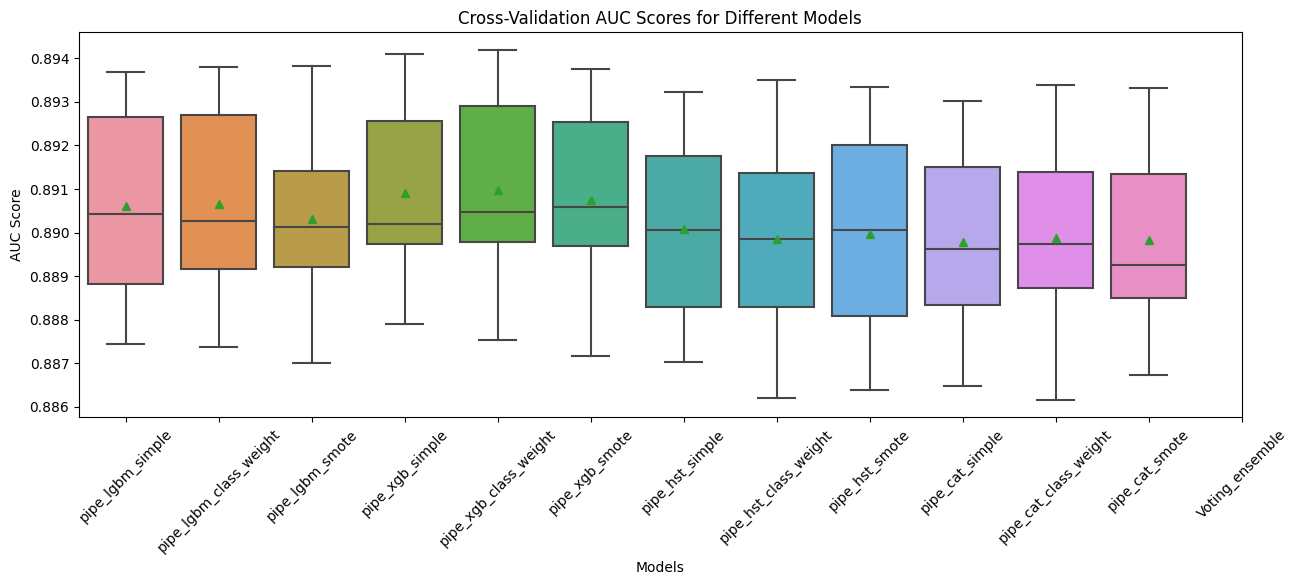

In [70]:
# Create a boxplot
plt.figure(figsize=(15, 5))
sns.boxplot(data=list(auc_scores.values()), showmeans=True)
plt.xticks(ticks=np.arange(len(models)), labels=list(models.keys()))
plt.xticks(rotation=45)
plt.title('Cross-Validation AUC Scores for Different Models')
plt.xlabel('Models')
plt.ylabel('AUC Score')
plt.show()

In [71]:
auc_scores

{'pipe_lgbm_simple': array([0.89264745, 0.8888214 , 0.89368778, 0.88744134, 0.89042371]),
 'pipe_lgbm_class_weight': array([0.89271056, 0.88915567, 0.89379852, 0.88736989, 0.89026887]),
 'pipe_lgbm_smote': array([0.89141295, 0.88920213, 0.89382609, 0.88700892, 0.89012092]),
 'pipe_xgb_simple': array([0.89256721, 0.88974359, 0.89410315, 0.88789513, 0.89019709]),
 'pipe_xgb_class_weight': array([0.89290548, 0.88978923, 0.89419602, 0.88753924, 0.8904794 ]),
 'pipe_xgb_smote': array([0.89254656, 0.8896998 , 0.89376387, 0.88716022, 0.89059831]),
 'pipe_hst_simple': array([0.89174733, 0.88829898, 0.89321711, 0.88703759, 0.89006482]),
 'pipe_hst_class_weight': array([0.89137936, 0.88830185, 0.89350653, 0.88621039, 0.88984449]),
 'pipe_hst_smote': array([0.89201943, 0.88808089, 0.89334715, 0.88638016, 0.89007109]),
 'pipe_cat_simple': array([0.89150365, 0.88834188, 0.89301074, 0.8864779 , 0.88961279]),
 'pipe_cat_class_weight': array([0.89139481, 0.88872543, 0.89337908, 0.88616358, 0.88973261]

In [72]:
df_results_df = pd.DataFrame.from_dict(auc_scores,orient = 'index', columns=['fold-1','fold2','fold3','fold4','fold5'])
df_results_df['Mean'] = df_results_df.mean(axis=1)
df_results_df['Std'] = df_results_df.std(axis=1)
df_results_df.sort_values(by = 'Mean', ascending=False).style.background_gradient('Reds')

,fold-1,fold2,fold3,fold4,fold5,Mean,Std
pipe_xgb_class_weight,0.892905,0.889789,0.894196,0.887539,0.890479,0.890982,0.002348
pipe_xgb_simple,0.892567,0.889744,0.894103,0.887895,0.890197,0.890901,0.002186
pipe_xgb_smote,0.892547,0.889700,0.893764,0.887160,0.890598,0.890754,0.002294
pipe_lgbm_class_weight,0.892711,0.889156,0.893799,0.887370,0.890269,0.890661,0.002336
pipe_lgbm_simple,0.892647,0.888821,0.893688,0.887441,0.890424,0.890604,0.002319
pipe_lgbm_smote,0.891413,0.889202,0.893826,0.887009,0.890121,0.890314,0.002269
pipe_hst_simple,0.891747,0.888299,0.893217,0.887038,0.890065,0.890073,0.002238
pipe_hst_smote,0.892019,0.888081,0.893347,0.886380,0.890071,0.889980,0.002533
pipe_cat_class_weight,0.891395,0.888725,0.893379,0.886164,0.889733,0.889879,0.002437
pipe_hst_class_weight,0.891379,0.888302,0.893507,0.886210,0.889844,0.889849,0.002504


# Model Evaluation

In [73]:
%%time
models = []

models.append(("pipe_lgbm_simple", pipe_lgbm_simple.named_steps['lgbm_tunned']))
models.append(("pipe_lgbm_class_weight", pipe_lgbm_class_weight.named_steps['lgbm_class_weight']))
models.append(("pipe_lgbm_smote", pipe_lgbm_smote.named_steps['lgbm_smote']))
models.append(("pipe_xgb_simple", pipe_xgb_simple.named_steps['xgb_simple']))
models.append(("pipe_xgb_class_weight", pipe_xgb_class_weight.named_steps['xgb_class_weight']))
models.append(("pipe_xgb_smote", pipe_xgb_smote.named_steps['xgb_smote']))
models.append(("pipe_hst_simple", pipe_hst_simple.named_steps['hst_simple']))
models.append(("pipe_hst_class_weight", pipe_hst_class_weight.named_steps['hst_class_weight']))
models.append(("pipe_hst_smote", pipe_hst_smote.named_steps['hst_smote']))
models.append(("pipe_cat_simple", pipe_cat_simple.named_steps['cat_simple']))
models.append(("pipe_cat_class_weight", pipe_cat_class_weight.named_steps['cat_class_weight']))
models.append(("pipe_cat_smote", pipe_cat_smote.named_steps['cat_smote']))
models.append(("Voting_ensemble", Voting_ensemble))
#models.append(("stacking_ensemble", stacking_ensemble))


accT = []

for name, model in models:
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict_proba(X_test)[:, 1]
        accT.append([name, roc_auc_score(y_test, y_pred)])


TypeError: All intermediate steps of the chain should not be Pipelines

In [74]:
results = pd.DataFrame(accT, columns=['model', 'AUC']).sort_values(by='AUC', ascending=False)

results.style.background_gradient('Reds')

,model,AUC
9,pipe_cat_simple,0.890786
4,pipe_xgb_class_weight,0.890712
10,pipe_cat_class_weight,0.890575
7,pipe_hst_class_weight,0.890399
11,pipe_cat_smote,0.890374
6,pipe_hst_simple,0.890169
3,pipe_xgb_simple,0.890132
8,pipe_hst_smote,0.890052
1,pipe_lgbm_class_weight,0.890005
5,pipe_xgb_smote,0.889891


In [105]:
disp = RocCurveDisplay.from_estimator(Voting_ensemble, X_test, y_test, name= 'Voting_ensemble')
RocCurveDisplay.from_estimator(pipe_lgbm_smote, X_test, y_test, name= 'pipe_lgbm_smote', ax=disp.ax_);
RocCurveDisplay.from_estimator(pipe_hst_smote, X_test, y_test, name= 'pipe_hst_smote', ax=disp.ax_);
RocCurveDisplay.from_estimator(pipe_lgbm_simple, X_test, y_test, name= 'pipe_lgbm_simple', ax=disp.ax_);
RocCurveDisplay.from_estimator(pipe_lgbm_class_weight, X_test, y_test, name= 'pipe_lgbm_class_weight', ax=disp.ax_);
RocCurveDisplay.from_estimator(pipe_xgb_class_weight, X_test, y_test, name= 'pipe_xgb_class_weight', ax=disp.ax_);
RocCurveDisplay.from_estimator(pipe_cat_class_weight, X_test, y_test,  name= 'pipe_cat_class_weight', ax=disp.ax_);
RocCurveDisplay.from_estimator(pipe_xgb_simple, X_test, y_test,  name= 'pipe_xgb_simple', ax=disp.ax_);
RocCurveDisplay.from_estimator(pipe_hst_class_weight, X_test, y_test,  name= 'pipe_hst_class_weight', ax=disp.ax_);
RocCurveDisplay.from_estimator(pipe_cat_simple, X_test, y_test,  name= 'pipe_cat_simple', ax=disp.ax_);
RocCurveDisplay.from_estimator(pipe_hst_simple, X_test, y_test,  name= 'pipe_hst_simple', ax=disp.ax_);
RocCurveDisplay.from_estimator(pipe_cat_smote, X_test, y_test,  name= 'pipe_cat_smote', ax=disp.ax_);
RocCurveDisplay.from_estimator(pipe_xgb_smote, X_test, y_test,  name= 'pipe_xgb_smote', ax=disp.ax_);

AttributeError: 'VotingClassifier' object has no attribute 'estimators_'

In [111]:
Voting_ensemble.estimators = [
    ('pipe_lgbm_simple', pipe_lgbm_simple.named_steps['lgbm_tunned']),
    ('pipe_lgbm_class_weight', pipe_lgbm_class_weight.named_steps['lgbm_class_weight']),
    ('pipe_lgbm_smote', pipe_lgbm_smote.named_steps['lgbm_smote']),
    ('pipe_xgb_simple', pipe_xgb_simple.named_steps['xgb_simple']),
    ('pipe_xgb_class_weight', pipe_xgb_class_weight.named_steps['xgb_class_weight']),
    ("pipe_xgb_smote", pipe_xgb_smote.named_steps['xgb_smote']),
    ("pipe_hst_simple", pipe_hst_simple.named_steps['hst_simple']),
    ("pipe_hst_smote", pipe_hst_smote.named_steps['hst_smote']),
    ("pipe_hst_class_weight", pipe_hst_class_weight.named_steps['hst_class_weight']),
    ("pipe_cat_simple", pipe_cat_simple.named_steps['cat_simple']),
    ("pipe_cat_class_weight", pipe_cat_class_weight.named_steps['cat_class_weight']),
    ("pipe_cat_smote", pipe_cat_smote.named_steps['cat_smote'])
]

Voting_ensemble.fit(X_train, y_train)
preds_test = Voting_ensemble.predict_proba(test_df)[:, 1]

ValueError: Number of features of the model must match the input. Model n_features_ is 51 and input n_features is 12